In [1]:
import os
from utils.loader import load_data, unicorn_fs, convert_to_mne, unicorn_eeg_channels
from mne.preprocessing import ICA
from utils.save_csv import save_csv
import mne

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8", "acc_x", "acc_y", "acc_z"]

In [2]:
path_data = 'data/dataset/playing_listening/relax'
files = [f for f in os.listdir(path_data) if f.endswith('.csv')]
path_file = os.path.join(path_data, files[0])

eeg, trigger, dataframe = load_data(path_file, header=False, fs=unicorn_fs, skiprows=5, names = unicorn_channels)
raw_data = convert_to_mne(eeg, trigger, fs=unicorn_fs, chs=unicorn_eeg_channels, recompute=False) 

# Filtering
filtered = raw_data.copy() 
filtered.notch_filter(50) 
filtered.notch_filter(60) 
filtered.filter(1,40)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,"8 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [6]:
n_components = 3

ica = ICA(n_components=n_components, max_iter="auto", random_state=97)
ica.fit(filtered)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,15 iterations on raw data (57500 samples)
ICA components,3
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [7]:
explained_var_ratio = ica.get_explained_variance_ratio(filtered)

for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: " f"{ratio}")

    for component in range(n_components):
        explained_var_ratio = ica.get_explained_variance_ratio(filtered, components=[component], ch_type=channel_type)
        ratio_percent = round(100 * explained_var_ratio[channel_type])
        print(
            f"Fraction of variance in {channel_type} signal explained by component {component}: "
            f"{ratio_percent}%"
        )

Fraction of eeg variance explained by all components: 0.7750682996039104
Fraction of variance in eeg signal explained by component 0: 12%
Fraction of variance in eeg signal explained by component 1: 37%
Fraction of variance in eeg signal explained by component 2: 28%


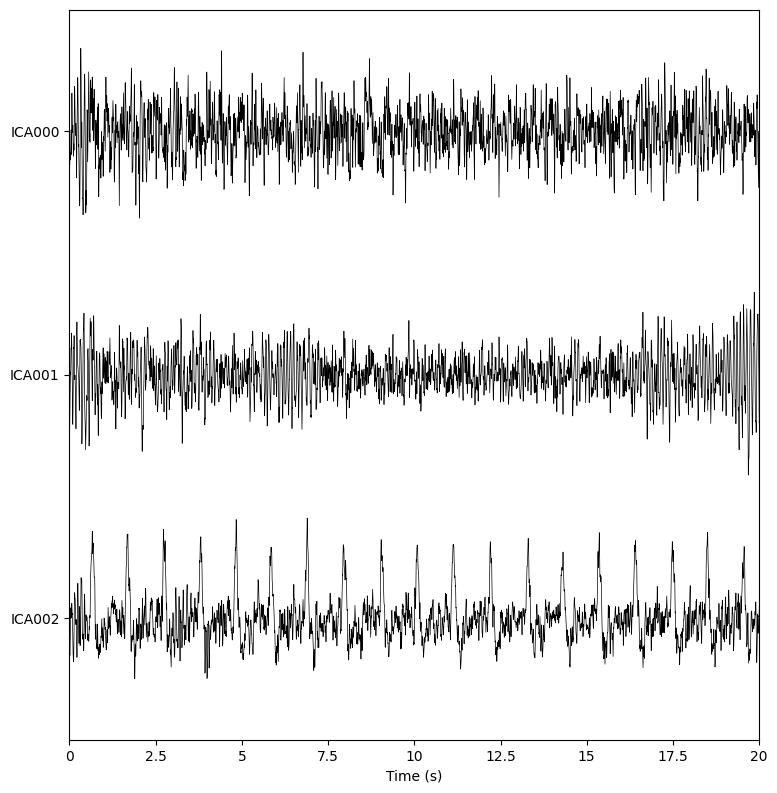

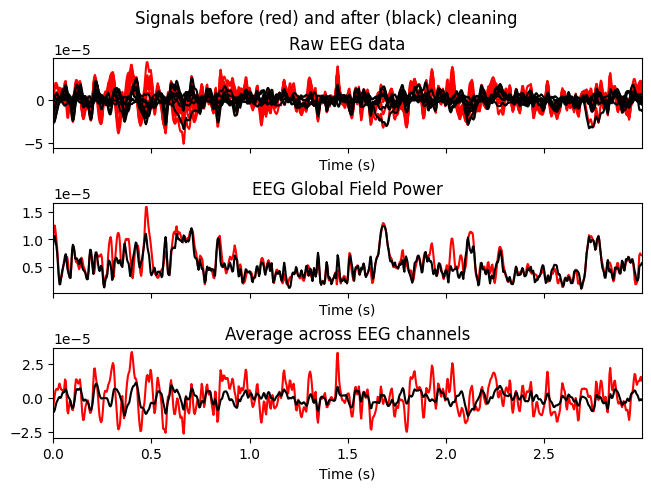

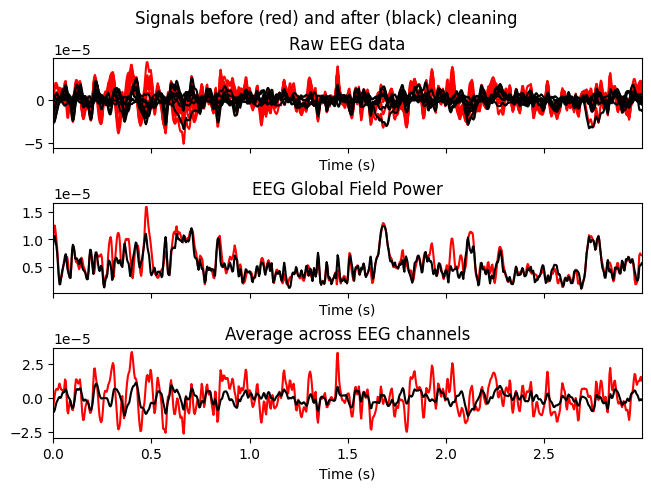

In [8]:
raw_data.load_data()
ica.plot_sources(raw_data, show_scrollbars=False)
ica.plot_overlay(raw_data, exclude=[0], picks="eeg")

C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\_figure.py:372: RuntimeWarning: Mean of empty slice
  data -= np.nanmean(data, axis=1, keepdims=True)


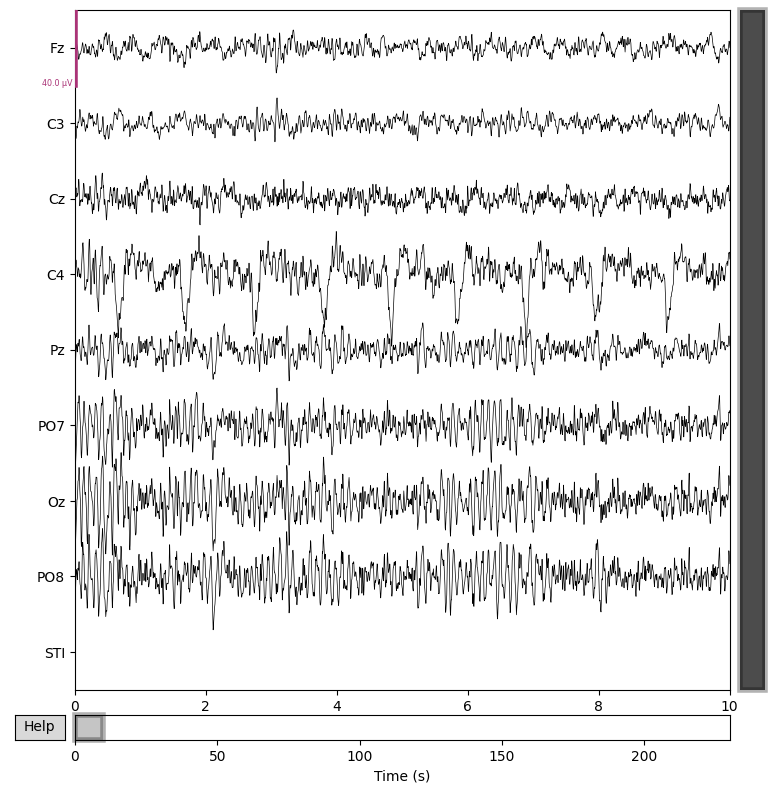

<RawArray | 9 x 57500 (230.0 s), ~4.0 MB, data loaded>


In [10]:
ica.exclude = [0]  # indices chosen based on various plots above
reconst_raw = raw_data.copy()
ica.apply(reconst_raw)

reconst_raw.plot(scalings=20e-6)

save_csv('ica.csv', reconst_raw)
print(reconst_raw)

# pxx_diff = reconst_raw.compute_psd(fmin=0, fmax=50)
# fig = pxx_diff.plot()
# plt.show()
# plt.close()